In [1]:
from typing import Tuple

import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from tqdm.notebook import tqdm

### Getting FFT matches

In [2]:
df_matches = pd.read_csv("../data/df_ucr_min_delta.csv")

In [3]:
df_matches.head()

,ts_1,no_1,class_1,ts_2,no_2,class_2,type,match_score,min_kpi,value
0,ACSF1,0,9,ACSF1,0,0,Welch,11001,d_m,0.000000e+00
1,ACSF1,0,9,ACSF1,89,89,Welch,11001,d_mean,8.904107e-11
2,ACSF1,0,9,ACSF1,6,6,Welch,11001,d_std,6.930145e-10
3,ACSF1,0,9,ACSF1,2,2,Welch,11001,d_q25,2.164000e-05
4,ACSF1,0,9,ACSF1,2,2,Welch,11001,d_q50,2.164000e-05


### Getting DTW matches

In [4]:
df_dtw = pd.read_csv("../data/df_dtw_comp.csv")

In [5]:
df_dtw.head()

,ts_1,no_1,class_1,ts_2,no_2,class_2,min_dtw_dist
0,ArrowHead,153,2,ArrowHead,8,2,11.453478
1,ArrowHead,154,2,ArrowHead,17,2,7.934686
2,InsectWingbeatSound,98,8,InsectWingbeatSound,175,7,24.418690
3,InsectWingbeatSound,174,5,InsectWingbeatSound,170,9,32.303582
4,InsectWingbeatSound,194,4,InsectWingbeatSound,61,4,16.177841


In [6]:
df_dtw[df_dtw['no_1']==12221]

,ts_1,no_1,class_1,ts_2,no_2,class_2,min_dtw_dist
688,Crop,12221,18,Crop,5324,18,0.50483


### Loading UCR data

In [7]:
ts_train_infos = []
ts_test_infos = []
for root, dirs, files in os.walk("../data/ucr_data/UCRArchive_2018/"):
    for name in files:
        if(name.endswith("_TRAIN.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_train_infos.append((ts_name, os.path.join(root,name)))
        elif(name.endswith("_TEST.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_test_infos.append((ts_name, os.path.join(root,name)))
            

In [8]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for ts_info in tqdm(ts_train_infos):
    ts_name = ts_info[0]
    fp = ts_info[1]
    
    df_tmp = pd.read_csv(fp, sep='\t', header=None)
    df_tmp['name'] = ts_name
    df_tmp['no'] = df_tmp.index
    cols = df_tmp.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_tmp = df_tmp[cols]
    df_train = df_train.append(df_tmp)
    
for ts_info in tqdm(ts_test_infos):
    ts_name = ts_info[0]
    fp = ts_info[1]
    
    df_tmp = pd.read_csv(fp, sep='\t', header=None)
    df_tmp['name'] = ts_name
    df_tmp['no'] = df_tmp.index
    cols = df_tmp.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_tmp = df_tmp[cols]
    df_test = df_test.append(df_tmp)
    
# df_train = df_train.reset_index().rename(columns={'index': 'no'})
# df_test = df_test.reset_index().rename(columns={'index': 'no'})
print("df_train shape: {}".format(df_train.shape))
print("df_test shape: {}".format(df_test.shape))

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

df_train shape: (64306, 2847)
df_test shape: (136855, 2847)


In [9]:
df_train.head()

,name,no,0,1,2,3,4,5,6,7,...,2835,2836,2837,2838,2839,2840,2841,2842,2843,2844
0,Haptics,0,5,-1.047477,0.548336,-0.259562,-1.581216,-1.915218,-1.278188,-0.691525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Haptics,1,2,-1.018153,0.514133,-0.097370,-1.374493,-1.957364,-1.567188,-0.906353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Haptics,2,4,-1.183382,0.339636,0.045998,-1.080209,-1.934357,-1.972025,-1.412721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Haptics,3,3,-0.896969,0.186145,0.578290,0.392361,-0.157240,-0.818047,-1.374046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Haptics,4,5,-1.009424,0.614673,-0.397552,-1.766144,-1.906942,-1.145026,-0.717200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plotting results

### Matches in FFT

Template series

UCR FFT Matches

In [11]:
def get_dtw_match(ts_name: str,
                  ts_no: int) -> Tuple[str, int,np.ndarray]:
    """ return matching series via DTW """
    s_tmp = df_dtw[(df_dtw['ts_1']==ts_name)&
           (df_dtw['no_1']==ts_no)].squeeze()
    ar = np.array(df_train[(df_train['name']==s_tmp['ts_2'])&
             (df_train['no']==s_tmp['no_2'])].iloc[:1,3:].dropna(axis=1))[0]
    return s_tmp['ts_2'], s_tmp['no_2'], ar
    

In [41]:
def random_results_comparison()->None:
    sample_idx = df_matches.set_index(['ts_1','no_1']).sample().index[0]
    ts_name = sample_idx[0]
    ts_no = sample_idx[1]
    print(ts_name)
    print(ts_no)


    df_tmp = df_matches[(df_matches['ts_1']==ts_name) &
              (df_matches['no_1']==ts_no)]

    kpis = list(df_tmp['min_kpi'].unique())

    ar_tmpl = np.array(df_test[(df_test['name']==ts_name) &
                          (df_test['no']==ts_no)].iloc[:,3:].dropna(axis=1))[0]

    dtw_name, dtw_no, dtw_ar = get_dtw_match(ts_name, ts_no)


    fig, axs = plt.subplots(4,2, figsize=(15,10))
    fig.tight_layout()

    # plots
    for i in range(8):
        axs.flatten()[i].plot(ar_tmpl, label="Templ: {} - {}".format(ts_name, ts_no))
        axs.flatten()[i].plot(dtw_ar, label="DTW: {} - {}".format(dtw_name, dtw_no))
        kpi = kpis[i] 
        axs.flatten()[i].set_title("{} - match".format(kpi))

        # get winner for particular KPI

        df_min = df_tmp[(df_tmp['ts_1']==ts_name) &
                (df_tmp['no_1']==ts_no) &
                (df_tmp['min_kpi']==kpi)]\
        .sort_values(['match_score','value'], ascending=[False,True])
        # take first entry as it is the lowest

        s_min = df_min.iloc[0,:].squeeze()
        name_tmp = s_min['ts_2']
        no_tmp = s_min['no_2']
        f_type = s_min['type']

        ar_min = np.array(df_train[(df_train['name']==name_tmp)&
           (df_train['no']==no_tmp)].iloc[:,3:].dropna(axis=1))[0]

        axs.flatten()[i].plot(ar_min, label="{}: {} - {}".format(f_type, name_tmp, no_tmp))
        axs.flatten()[i].legend()


    fig.savefig("../img/dtw_fft_comp/{}_{}_ucr_dtw_fft_comp.png".format(ts_name,ts_no))

PigAirwayPressure
127
UWaveGestureLibraryAll
1961
UWaveGestureLibraryAll
609
ToeSegmentation1
49
ItalyPowerDemand
179
Phoneme
1606
ShapesAll
188
SmoothSubspace
71
Mallat
1407
AllGestureWiimoteX
695


ValueError: Can only compare identically-labeled Series objects

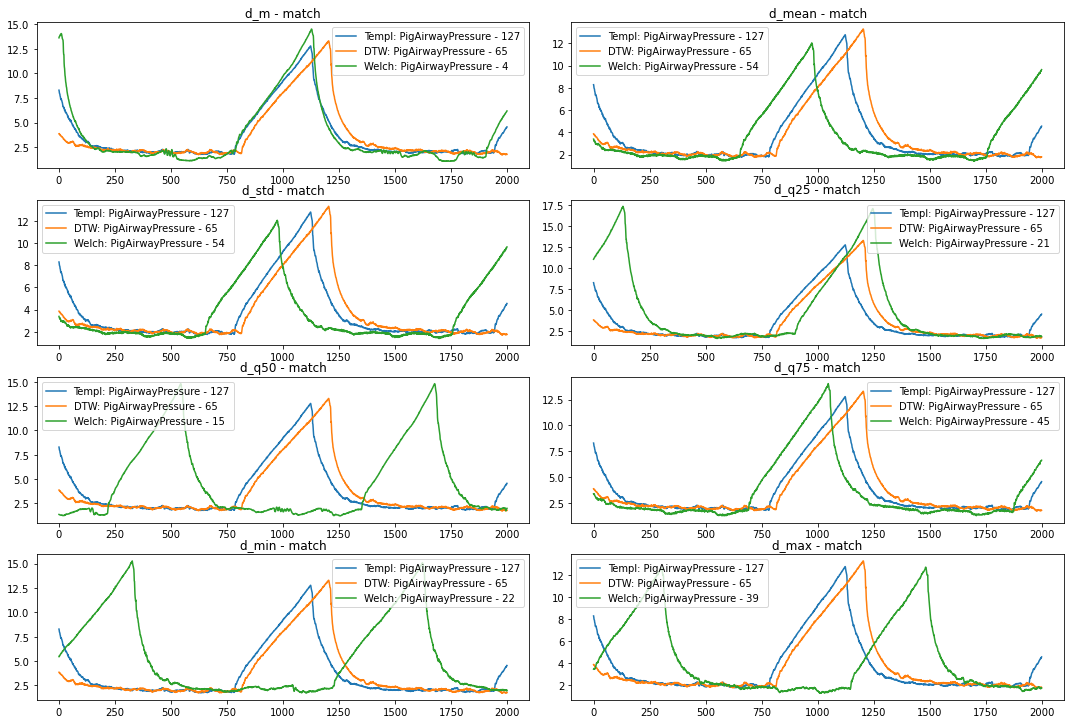

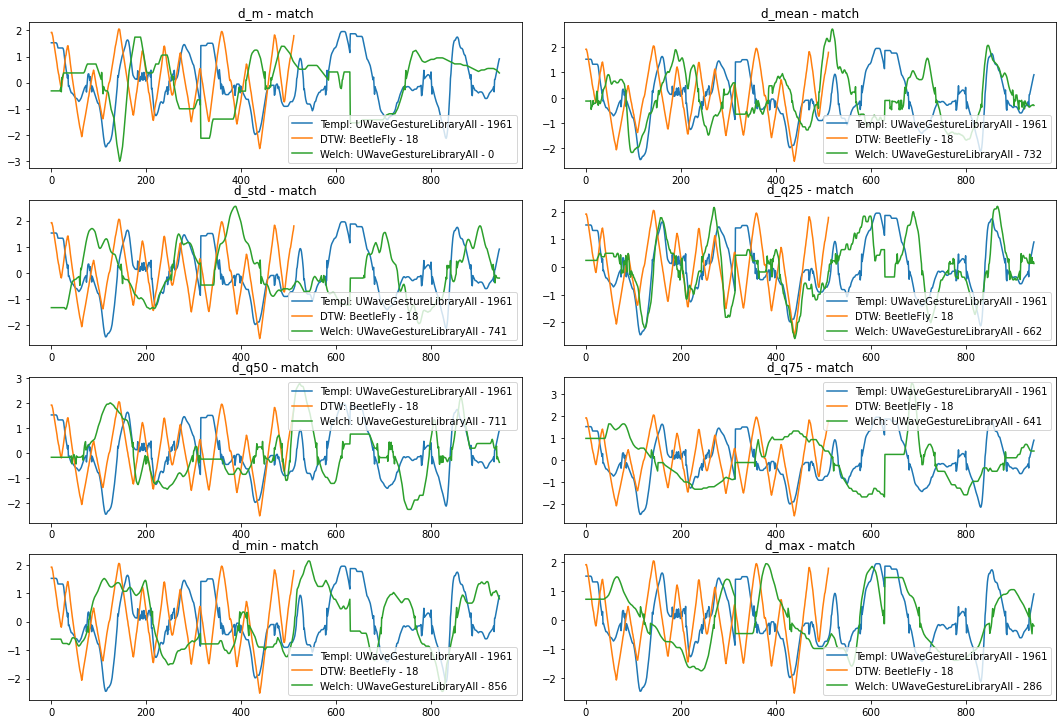

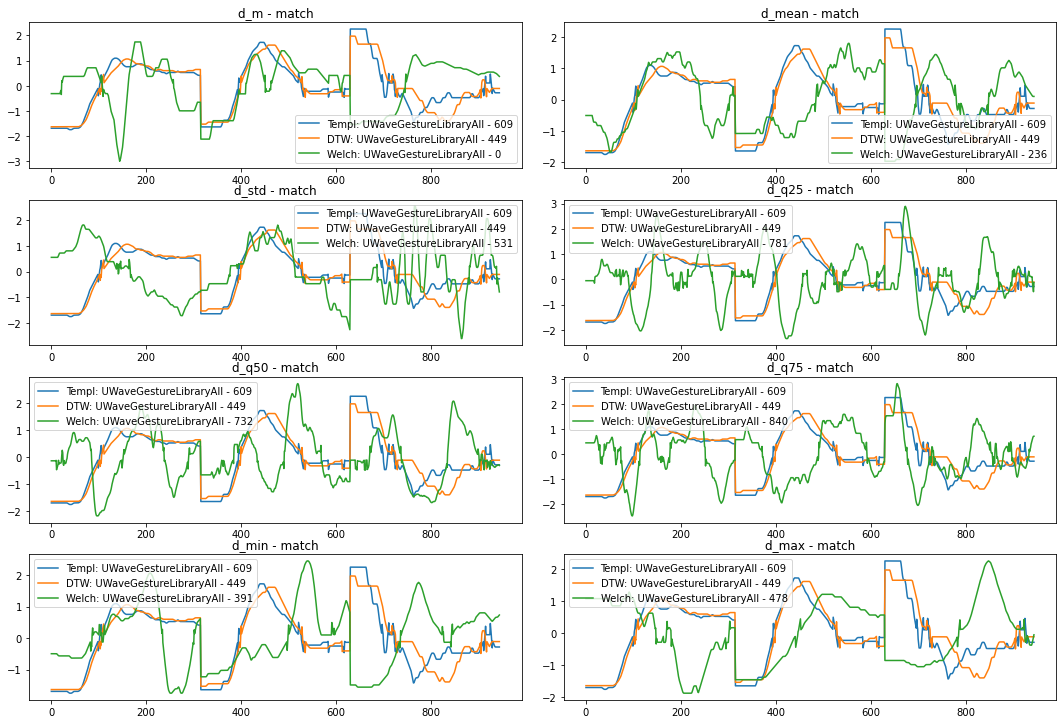

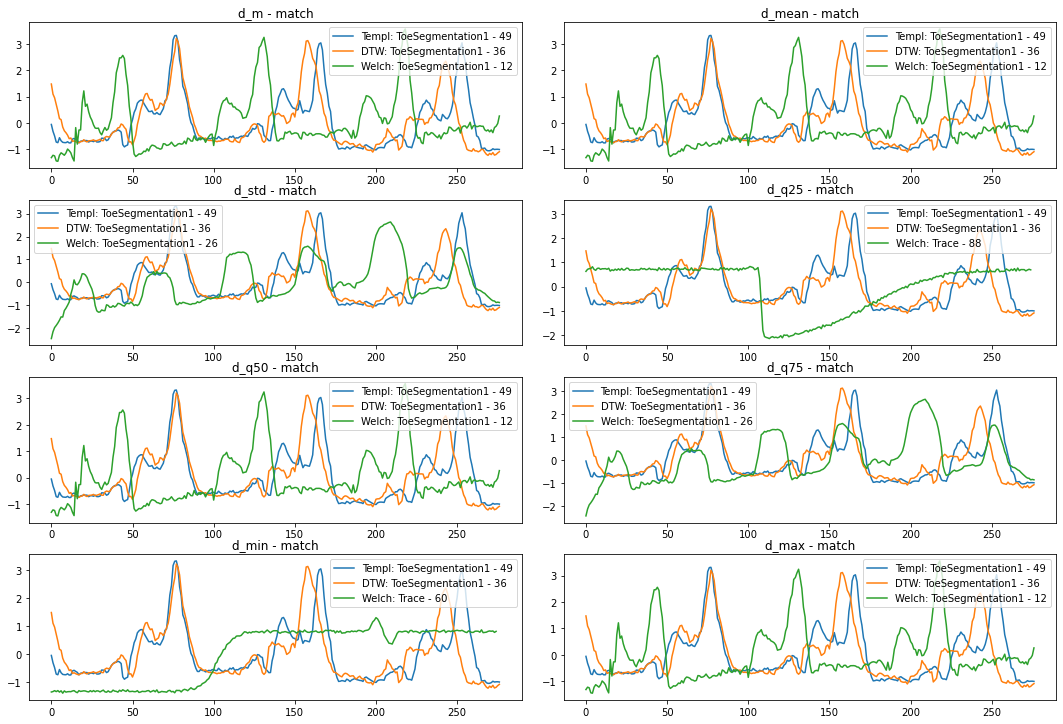

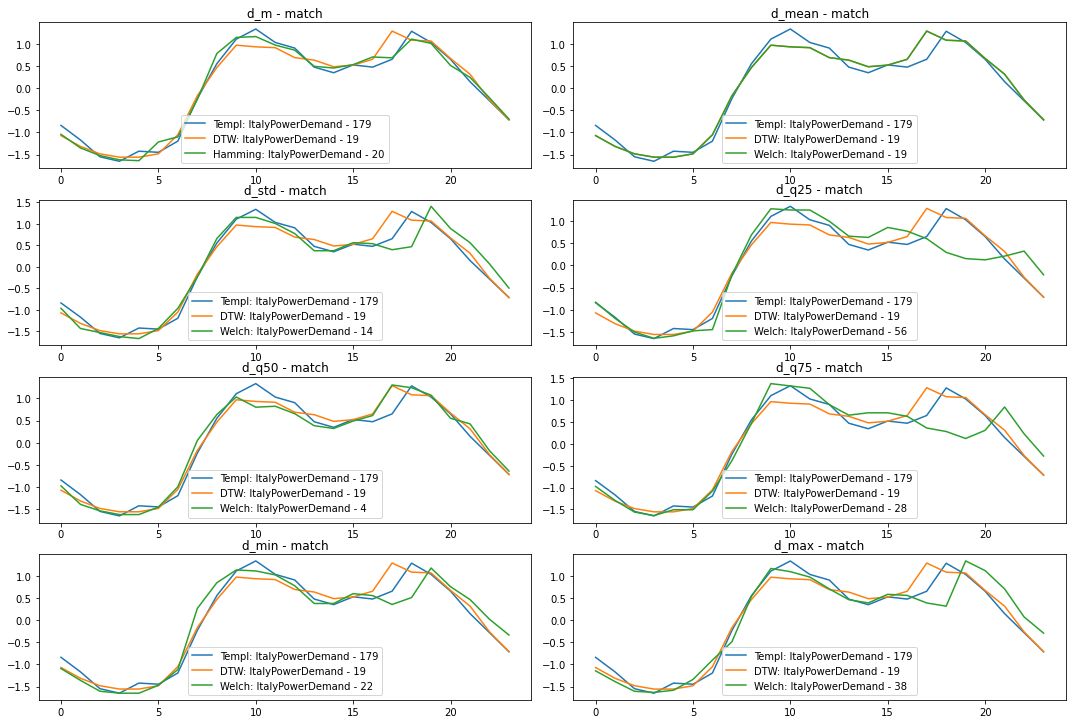

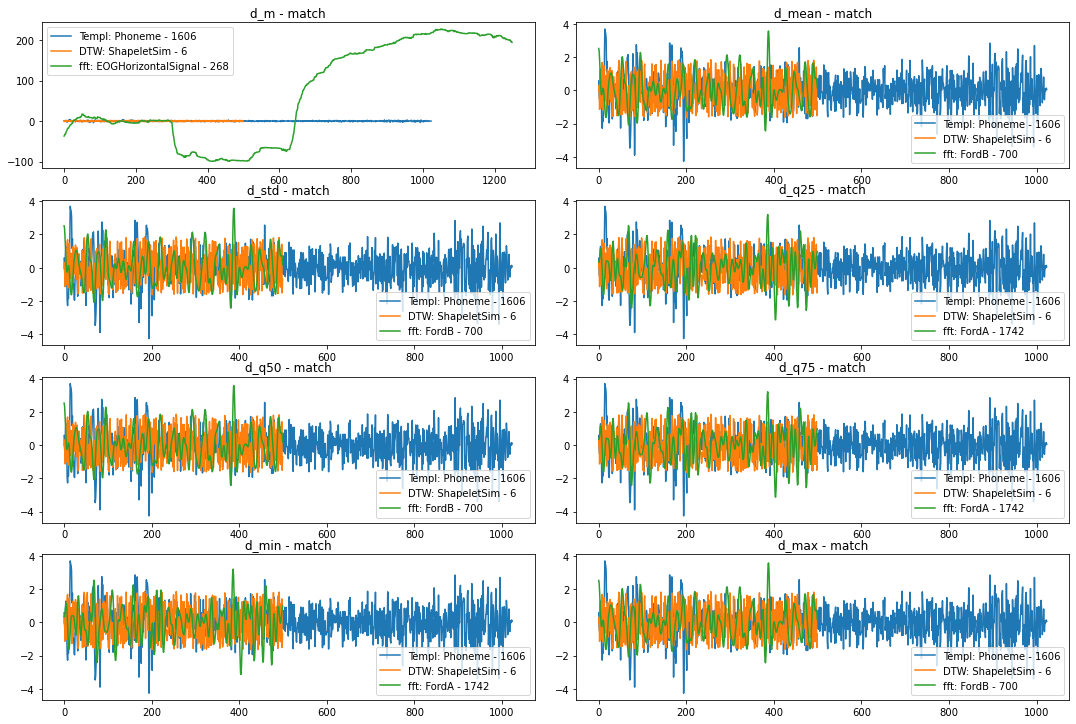

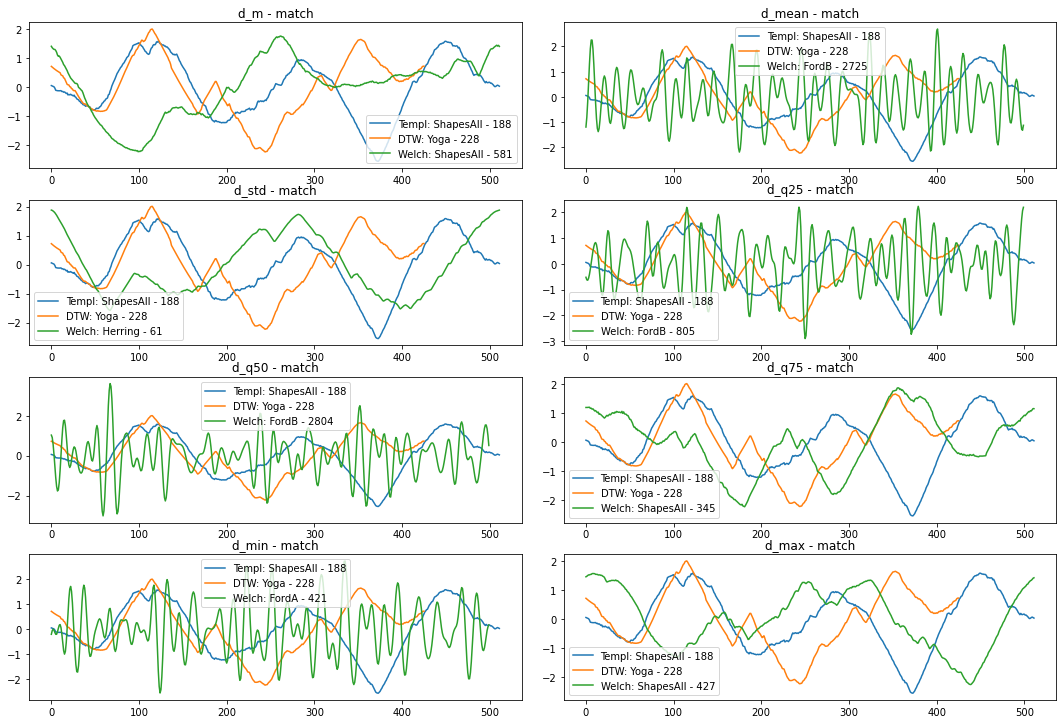

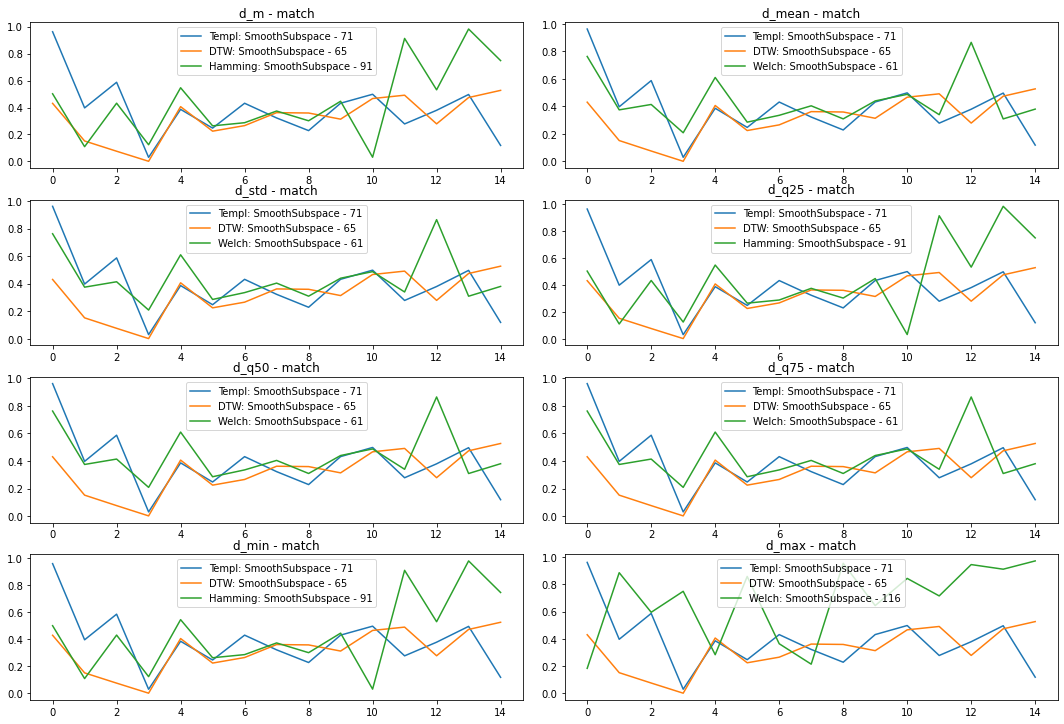

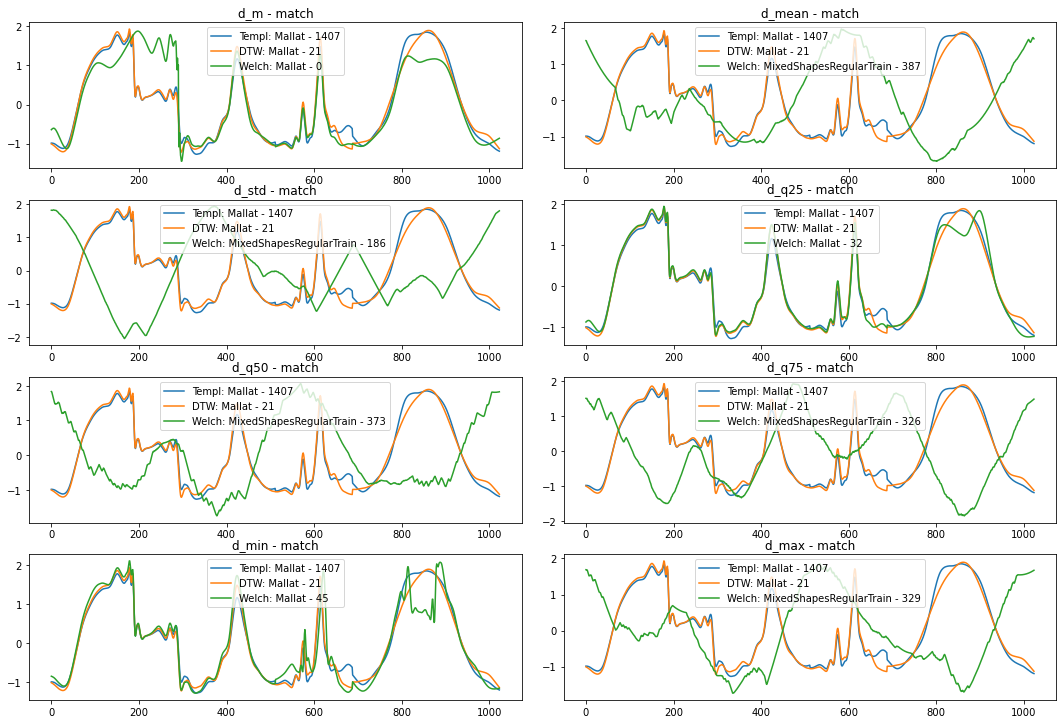

In [44]:
for i in range(30):
    random_results_comparison()

### Remember df_test

PigAirwayPressure 124

ToeSegmentation1 202

SonyAIBORobotSurface2 612

SmoothSubspace 126

InsectWingbeatSound 1662

PigAirwayPressure

ProximalPhalanxOutlineCorrect - 273

FFT Failure: FaceFour 66

Haptics - 266

Phoneme - 1787

FordB - 590

FFT bad: EOGHorizontalSignal - 215

good example: FaceFour - 51

FFT advantage through closeness of spikes: LargeKitchenAppliances - 0

Sin/Cos at work: Mallat - 1506

case for building ranges/thresholds: FreezerSmallTrain - 1430

further fine-tuning of parameters for selection required: PowerCons - 81

Ham 56

ECGFiveDays 495

issue with magnitude: BME 86

FreezerRegularTrain 278

CricketZ 222

In [229]:
AllGestureWiimoteZ
203

NameError: name 'AllGestureWiimoteZ' is not defined

In [192]:
df_train[(df_train['name']=='AllGestureWiimoteZ')&
             (df_train['no']==203)]

,name,no,0,1,2,3,4,5,6,7,...,2835,2836,2837,2838,2839,2840,2841,2842,2843,2844
203,AllGestureWiimoteZ,203,7,1.038,0.923,0.923,0.923,0.923,0.962,0.962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,AllGestureWiimoteZ,203,7,1.038,0.923,0.923,0.923,0.923,0.962,0.962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df.head()

,name,2844,0,1,2,3,4,5,6,7,...,2834,2835,2836,2837,2838,2839,2840,2841,2842,2843
0,Haptics,NaN,5,-1.047477,0.548336,-0.259562,-1.581216,-1.915218,-1.278188,-0.691525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Haptics,NaN,2,-1.018153,0.514133,-0.097370,-1.374493,-1.957364,-1.567188,-0.906353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Haptics,NaN,4,-1.183382,0.339636,0.045998,-1.080209,-1.934357,-1.972025,-1.412721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Haptics,NaN,3,-0.896969,0.186145,0.578290,0.392361,-0.157240,-0.818047,-1.374046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Haptics,NaN,5,-1.009424,0.614673,-0.397552,-1.766144,-1.906942,-1.145026,-0.717200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
